## **Project: Ho Chi Minh City Weather Forecasting Model**

### **Description**

The aim of this project is to implement a weather forecasting model using machine learning algorithms, with the improvement in accuracy.

The notebook will investigate the performance of different regression model and applied it into a Azure Machine Learning (Azure ML) Pipeline. Despite Azure ML also providing the Automated ML and Notebook services, it is also consume the compute instance which could potentially costs a lot. Therfore, we can examine the choices on our separated notebook to see the right model and right hyperparameters, then integrate them into the Azure ML.

The pipeline will use the OpenWeather API to get the weather data at Ho Chi Minh City daily, and feed it into our model. Other aims of this project are also considerable, such as pipeline scheduling, monitor data drifting and email alert/notification.



> References: https://www.tensorflow.org/tutorials/structured_data/time_series



### **Notebook Implementation**

In [73]:
# Import libraries
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import tensorflow as tf
from tensorflow.keras import Model

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## **1. Dataset Information**

**Location:** Ho Chi Minh City, Vietnam

**Timestamps:** 01/01/2001 - 20/06/2021 (nearly up to today)

**Target variable:** Temperature/Weather Condition

The dataset is retrieved from OpenWeather database, with the price of 10$ for buying daily weather data in one specific location and timeline.

## **2. Dataset Exploration**

Historical Weather Data of Ho Chi Minh City

In [26]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Weather Forecasting/'

In [138]:
df = pd.read_csv('weather_hcm_20yrs.csv')
df.head(5)

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,...,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,978307200,2001-01-01 00:00:00 +0000 UTC,25200,Ho Chi Minh City,10.823099,106.629664,21.87,25.26,21.40,23.09,...,26,NaN,NaN,NaN,NaN,20,701,Mist,mist,50d
1,978310800,2001-01-01 01:00:00 +0000 UTC,25200,Ho Chi Minh City,10.823099,106.629664,22.83,25.72,22.18,23.00,...,350,NaN,NaN,NaN,NaN,20,701,Mist,mist,50d
2,978314400,2001-01-01 02:00:00 +0000 UTC,25200,Ho Chi Minh City,10.823099,106.629664,26.13,29.56,26.00,26.49,...,10,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02d
3,978318000,2001-01-01 03:00:00 +0000 UTC,25200,Ho Chi Minh City,10.823099,106.629664,26.96,29.98,26.60,27.10,...,10,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02d
4,978321600,2001-01-01 04:00:00 +0000 UTC,25200,Ho Chi Minh City,10.823099,106.629664,27.57,30.91,26.84,28.00,...,349,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02d


In [55]:
df['weather_main'].unique()

array(['Mist', 'Clouds', 'Rain', 'Clear', 'Haze', 'Thunderstorm',
       'Drizzle', 'Fog', 'Squall'], dtype=object)

Besides of temperature that is usually used as target variable, `weather_main` attribute can also consider to be one as well. But since it is a categorical attribute which does not align with the time-series concept in this notebook, we will not take it into account.

### **List of features**

Features | Description
-------------------|------------------
dt      | Time of data calculation, unix, UTC
dt_iso     | Date and time in UTC format
timezone      | Shift in seconds from UTC
city_name       | City name
lat      | Geographical coordinates of the location (latitude)
lon | Geographical coordinates of the location (longitude)
temp      | Temperature
feels_like     | Temperature parameter accounts for the human perception of weather
temp_min    | Minimum temperature at the moment
temp_max    | Maximum temperature at the moment 
pressure | Atmospheric pressure (on the sea level) (hPa)
humidity | Humidity (%)
sea_level | Sea level of location
grnd_level | Ground level of location
wind_speed  |Wind speed (meter/sec)
wind_deg | Wind direction, degrees (meteorological)
clouds_all | Cloudiness (%)
rain_1h | Rain volume for the last hour (mm)
rain_3h | Rain volume for the last 3 hours (mm)
snow_1h | Snow volume for the last hour (mm) (in liquid state)
snow_3h | Snow volume for the last 3 hours (mm) (in liquid state)
weather_id | Weather condition id
weather_main | Group of weather parameters (Rain, Snow, Extreme etc.)
weather_description | Weather condition within the group
weather_icon | Weather icon id

There are features such as `timezone`, `sea_level`, `grnd_level`, `weather_icon` and `snow` attributes that are unnecessary. Since Vietnam is a country that barely witness snow season, especially in Ho Chi Minh City, removing this feature will not harm this model (completely NaN).

Other features that do not contain any pieces of data, or features that stay same such as `city_name`, `latitude` and `longtitude` will be removed. The `dt_iso` can be discarded as well since we are going to use the unix format of the timestamp (dt attributes)

### **Check missing values**

In [112]:
# Check missing values
def check_missing(df):
    # Create a hash dictionary contain missing ratio of each feature
    miss_dict = {}
    for columns in df:
        count = df[columns].isna().sum()
        ratio = count/len(df[columns])
        datatype = df[columns].dtype
        miss_dict[columns] = [count, ratio, datatype]
    
    return miss_dict

In [113]:
miss_ratio = pd.DataFrame(check_missing(df), ['MissCounts', 'MissRatio', 'Type']).T
print("Missing ratio table")
miss_ratio

Missing ratio table


,MissCounts,MissRatio,Type
dt,0,0.0,int64
dt_iso,0,0.0,object
timezone,0,0.0,int64
city_name,0,0.0,object
lat,0,0.0,float64
lon,0,0.0,float64
temp,0,0.0,float64
feels_like,0,0.0,float64
temp_min,0,0.0,float64
temp_max,0,0.0,float64


**Displaying feature having missing ratio > 0**

In [114]:
miss_feature = miss_ratio[miss_ratio.MissRatio > 0]
print("Total feature missing values: {}".format(len(miss_feature)))
miss_feature

Total feature missing values: 6


,MissCounts,MissRatio,Type
sea_level,181267,1.0,float64
grnd_level,181267,1.0,float64
rain_1h,166468,0.918358,float64
rain_3h,181267,1.0,float64
snow_1h,181267,1.0,float64
snow_3h,181267,1.0,float64


**Removing low-fetched data**

In [139]:
df = df.drop(columns=['dt_iso', 'city_name', 'lat', 'lon', 'timezone', 'sea_level',
                      'grnd_level', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h',
                      'weather_icon', 'weather_description', 'weather_id'])

dt = pd.to_datetime(df['dt'], unit='s')
# weather_cond = df.pop('weather_main')

In [140]:
df.head(5)

,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main
0,978307200,21.87,25.26,21.40,23.09,1011,96,1.28,26,20,Mist
1,978310800,22.83,25.72,22.18,23.00,1012,83,1.00,350,20,Mist
2,978314400,26.13,29.56,26.00,26.49,1012,73,1.00,10,20,Clouds
3,978318000,26.96,29.98,26.60,27.10,1012,66,1.00,10,20,Clouds
4,978321600,27.57,30.91,26.84,28.00,1011,65,0.78,349,20,Clouds


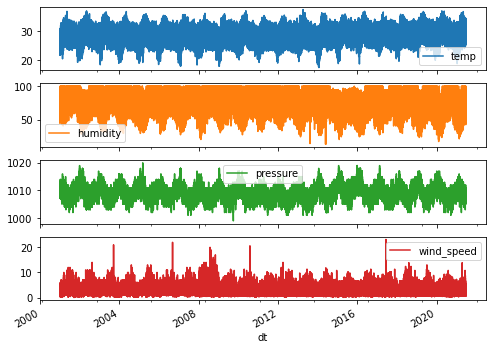

In [141]:
features = ['temp', 'humidity', 'pressure', 'wind_speed']
df_features = df[features]
df_features.index = dt
_ = df_features.plot(subplots=True)

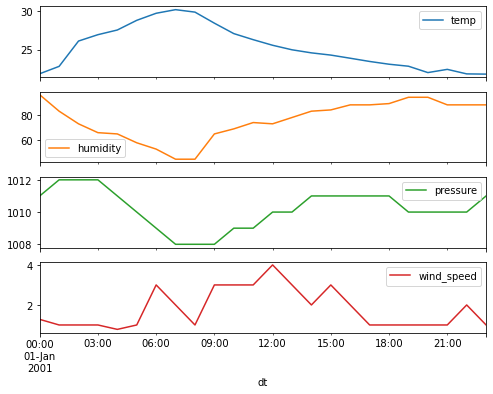

In [142]:
plot_features = df[features][:24]
plot_features.index = dt[:24]
_ = plot_features.plot(subplots=True)

### **Cleanup data**

We will look at the statistics of dataset for some configuration.

In [143]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
dt,181267.0,1.300236e+09,1.861942e+08,9.783072e+08,1.139423e+09,1.299056e+09,1.461404e+09,1.624230e+09
temp,181267.0,2.766711e+01,2.838694e+00,1.752000e+01,2.561000e+01,2.717000e+01,2.971000e+01,3.748000e+01
feels_like,181267.0,3.102620e+01,2.925429e+00,1.572000e+01,2.922000e+01,3.101000e+01,3.296000e+01,4.096000e+01
temp_min,181267.0,2.679300e+01,2.509630e+00,1.700000e+01,2.500000e+01,2.658000e+01,2.852000e+01,3.580000e+01
temp_max,181267.0,2.840910e+01,2.815747e+00,1.945000e+01,2.629000e+01,2.800000e+01,3.038000e+01,4.035000e+01
pressure,181267.0,1.009199e+03,2.428657e+00,9.990000e+02,1.008000e+03,1.009000e+03,1.011000e+03,1.020000e+03
humidity,181267.0,7.785702e+01,1.610538e+01,1.400000e+01,6.600000e+01,7.900000e+01,9.200000e+01,1.000000e+02
wind_speed,181267.0,2.838664e+00,1.625100e+00,1.000000e-02,1.500000e+00,2.600000e+00,4.000000e+00,2.315000e+01
wind_deg,181267.0,1.579629e+02,1.045604e+02,0.000000e+00,7.000000e+01,1.600000e+02,2.400000e+02,3.600000e+02
clouds_all,181267.0,4.604493e+01,2.225943e+01,0.000000e+00,4.000000e+01,4.000000e+01,7.500000e+01,1.000000e+02


With a glance at the table, it seems like our values (except wind_speed) are fine and can be used for later Feature Engineering.

## **3. Feature Engineering**

### **Attributes inspection**

**Wind**

In our dataset, the **wind_deg** value is kind of unpredictable and not so useful for our model, as if the degree values of 360 and 0 is close to each other. One more thing has to be note is that if the wind is not blowing, there the wind direction value is not matter anymore.

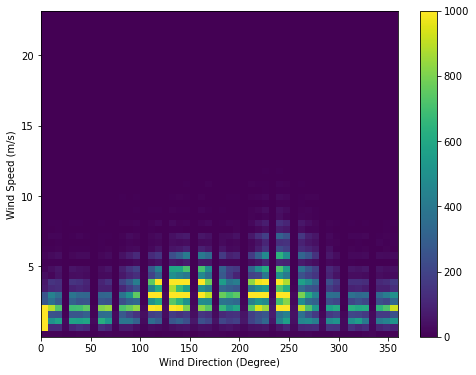

In [144]:
plt.hist2d(df['wind_deg'], df['wind_speed'], bins=(50,50), vmax=1000)
plt.xlabel('Wind Direction (Degree)')
plt.ylabel('Wind Speed (m/s)')
plt.colorbar()

Convert wind velocity and direction into vectors

In [145]:
wind_speed = df['wind_speed']
wind_rad = df.pop('wind_deg')*np.pi / 180
df['wind_x'] = wind_speed*np.cos(wind_rad)
df['wind_y'] = wind_speed*np.sin(wind_rad)

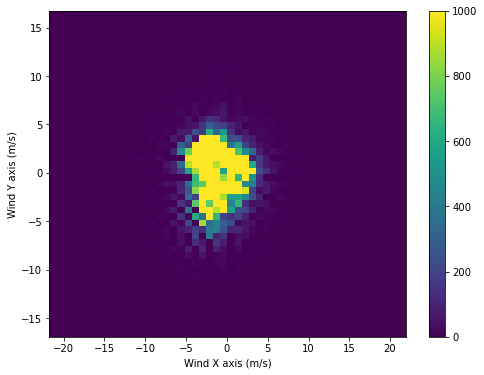

In [146]:
plt.hist2d(df['wind_x'], df['wind_y'], bins=(50,50), vmax=1000)
plt.xlabel('Wind X axis (m/s)')
plt.ylabel('Wind Y axis (m/s)')
plt.colorbar()

**Time**

Similar to wind, the date time feature is not very useful in the string form. Converting it to the smallest form, which is **second**, will helps the model to work better. Also, from second type, we should convert the date time to a periodical form, as if the weather data has sort of daily, monthly or yearly data type (credit to TensorFlow documentation)

In [147]:
timestamp_s = dt.map(pd.Timestamp.timestamp)

In [148]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of Year signal')

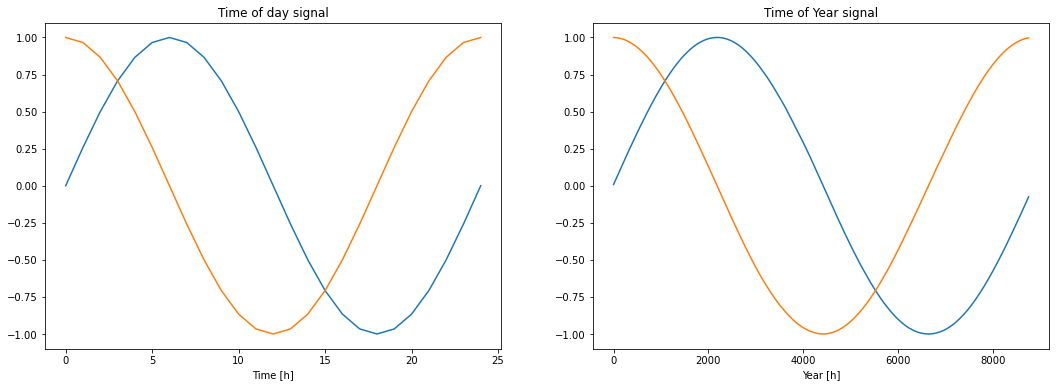

In [149]:
fig, axes = plt.subplots(1,2, figsize=(18,6))
axes[0].plot(np.array(df['Day sin'])[:25])
axes[0].plot(np.array(df['Day cos'])[:25])
axes[0].set_xlabel('Time [h]')
axes[0].set_title('Time of day signal')

axes[1].plot(np.array(df['Year sin'])[:8760])
axes[1].plot(np.array(df['Year cos'])[:8760])
axes[1].set_xlabel('Year [h]')
axes[1].set_title('Time of Year signal')

Determine the important frequencies

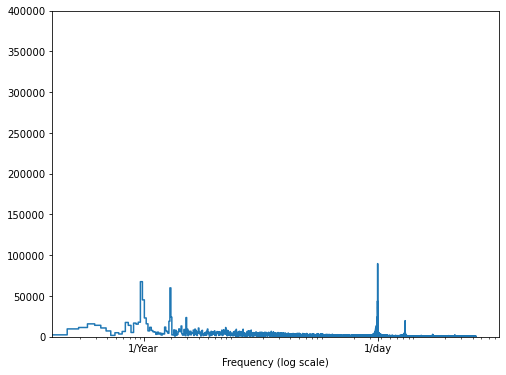

In [150]:
fft = tf.signal.rfft(df['temp']) # Computes the 1-dimensional discrete Fourier transform
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['temp'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

#### **Export cleaned data**

In [151]:
df_clean = df.copy()
df_clean.to_csv('weather_hcm_20yrs_cleaned.csv', index=False)

### **Split data**

Here we will split the data into training, validation and test sets. The data is not randomly splitted since we want the chunks to be consecutive.

In [22]:
col_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

n_features = df.shape[1]

**Normalize data**

In [159]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean)/train_std
val_df = (val_df - train_mean)/train_std
test_df = (test_df - train_mean)/train_std

## **4. Model Interpret**

### **Data Windowing**

The time series model mechanism is making a set of predictions based on the consecutive samples extracted from data.

The main features of inputs are:

* The width (time steps) of the input and label
* The offset between input and label
* Features that used as inputs, label, or both

In this project, we will focus on the models that make single-output predictions.

Since the time series forecasting is not as simple as the normal models or machine learning pipeline, framing the data into fixed windows will help us easier interpreting and tracking.

Reason: Data windowing provides the model the complete information at a given time point in the past, and it makes the input become a sort of mini data-structure so we can know how the parameters will affect the model.

An example for input window: make a prediction 2 hour into the future based on the 8h history of data.

![picture](https://drive.google.com/uc?export=view&id=11kcKD82tvcKFnilSbiwpX2UcyV_HOhM6)

#### **WindowFrame Class**

We start creating an class to frame the data into windows with offset and indexes.

In [161]:
class WindowFrame():
    """
    A class that store the input, label, and offset
    of time series forecating parameters into window
    """
    def __init__(self, input_width, label_width, offset,
             train_df = train_df, val_df = val_df,
             test_df = test_df, label_cols = None):
      # Store the initial data
      self.train_df = train_df
      self.val_df = val_df
      self.test_df = test_df

      # Store the label columns indices into dictionary
      # (The features that are use as labels)
      self.label_cols = label_cols
      if label_cols is not None:
        self.label_cols_indices = {name: i for i, name in
                                   enumerate(label_cols)}
      
      # Store the columns indices of train set into dictionary
      self.cols_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

      # Setting for the window parameters
      self.input_width = input_width
      self.label_width = label_width
      self.offset = offset

      self.total_window_width = input_width + offset

      # Slice parts of window as input
      self.input_slice = slice(0, input_width)
      self.input_indices = np.arange(self.total_window_width)[self.input_slice]

      # Label width can be greater (multi-output)
      self.label_start = self.total_window_width - self.label_width
      self.label_slice = slice(self.label_start, None)
      self.label_indices = np.arange(self.total_window_width)[self.label_slice]

    def __repr__(self):
        return '\n'.join([f'Total window width: {self.total_window_width}',
                          f'Input indices: {self.input_indices}',
                          f'Label indices: {self.label_indices}',
                          f'Label column name(s): {self.label_cols}'])
    

Now we will make two examples using WindowFrame class, one of which is based on the diagram we mentioned above:

In [23]:
w1 = WindowFrame(input_width=8, label_width=1, offset=2,
                 label_cols=['temp'])

w1

Total window width: 10
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [9]
Label column name(s): ['temp']

The label indices is 9 inidicate that our class has worked very well based on the parameters inserted.

Another example is making prediction 12h into the future base on 6h history of data:


In [24]:
w2 = WindowFrame(input_width=12, label_width=1, offset=6,
                 label_cols=['temp'])

w2

Total window width: 18
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [17]
Label column name(s): ['temp']

#### **Split window**

Based on the object that have been created, we can split the consecutive inputs into a window of inputs (exclude labels) and a window of labels

In [164]:
def split_window(self, features):
  
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.label_slice, :]

  if self.label_cols is not None:
    labels = tf.stack([labels[:, :, self.cols_indices[name]] for name in self.label_cols],
                      axis=-1)
    
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowFrame.split_window = split_window

We will try out on the example w2:

In [26]:
# Stack the window with 3 batches
test_window = tf.stack([np.array(train_df[:w2.total_window_width]),
                        np.array(train_df[100:100+w2.total_window_width]),
                        np.array(train_df[200:200+w2.total_window_width])])

test_inputs, test_labels = w2.split_window(test_window)

print('Shapes format: (batch, time, features)')
print(f'Window shape: {test_window.shape}')
print(f'Inputs shape: {test_inputs.shape}')
print(f'Labels shape: {test_labels.shape}')

Shapes format: (batch, time, features)
Window shape: (3, 18, 13)
Inputs shape: (3, 12, 13)
Labels shape: (3, 1, 1)


All of the shapes that have displayed above indicate the number of batches (first index), the timestep dimension (second index), and number of features (third index).

The test above show us that it tooks 3 batches, 18-timestep window with 13 features at each timestep. From the window, it split into a batch includes: inputs with 12 timestep, 13 features and labels with 1 timestep, 1 feature.

Since the w2 object initialized `label_cols=['temp']`, the label only has one feature (as we initially stated to only focus on model that predict single output labels)

#### **Plot window**

In [27]:
w2.example = test_inputs, test_labels

In [165]:
def plot(self, model=None, plot_col='temp', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.cols_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_cols:
      label_col_index = self.label_cols_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowFrame.plot = plot

Plotting with default column temperature

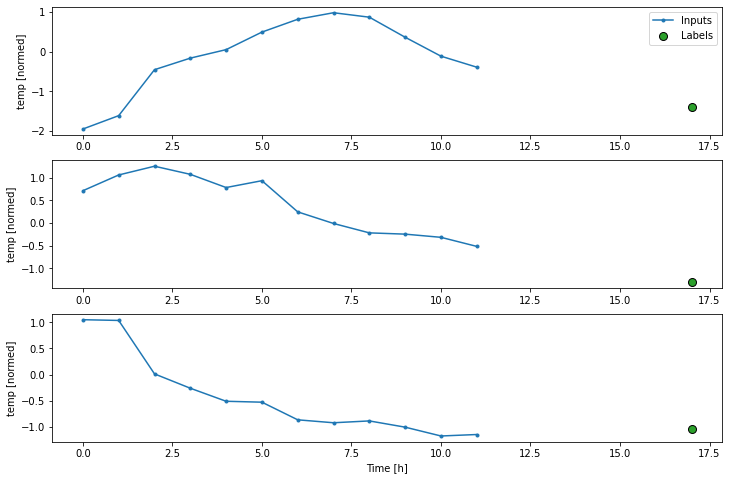

In [29]:
w2.plot()

Plotting with other column (pressure)

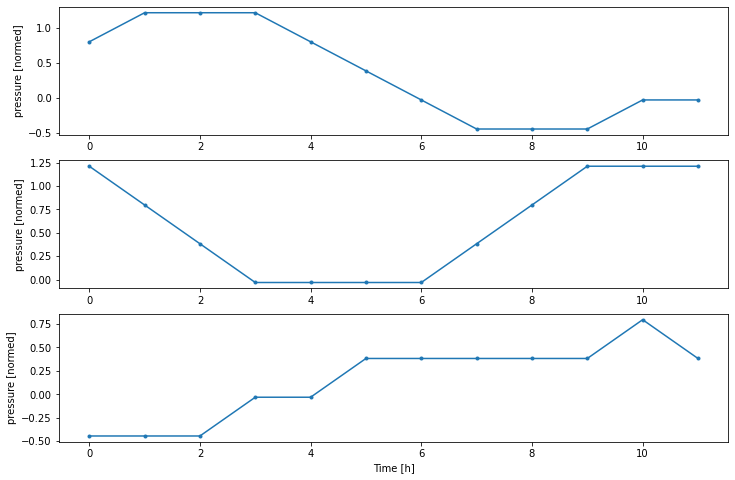

In [30]:
w2.plot(plot_col='pressure')

#### **Create Dataset with TF**

Next we will create a method that create the a time-series dataset and convert it to `tf.data.Dataset` with the aid of keras function. This method also let the `split_window` function attach with the provided data.

In [167]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_width,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowFrame.make_dataset = make_dataset

In [168]:
@property 
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found -> Grab one from `.train` dataset
    result = next(iter(self.train))
    # Cache the grabbed one for next time
    self._example = result
  return result

WindowFrame.train = train
WindowFrame.val = val
WindowFrame.test = test
WindowFrame.example = example

With the `make_dataset` function we have defined above, each type of dataset (train, val, test) will have a structure as a pair of (inputs, label). We can see the structure, data types and shapes with the `Dataset.element_spec` property.

In [33]:
w2.train.element_spec

(TensorSpec(shape=(None, 12, 13), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Here the output indicates that the train dataset have the input with a shape consist of (12, 13) which represent for 12 timestep and 13 features

And the output's shape is (1,1) as we are interpreting the single output model.

In [34]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Outputs shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 12, 13)
Outputs shape (batch, time, features): (32, 1, 1)


### **Single Step Model**

In [35]:
single_step_window = WindowFrame(input_width=1, label_width=1, offset=1,
                                 label_cols=['temp'])

single_step_window

Total window width: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['temp']

Using the same lines as `cell 45`, we can create the training tf.data.Dataset and iterate over batches of it.

In [36]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Outputs shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 13)
Outputs shape (batch, time, features): (32, 1, 1)


#### **Baseline**

In [37]:
class Baseline(Model):
  def __init__(self, label_index = None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs # Return the current temperature if no changes
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [38]:
# Instantiate and evaluate this model
baseline = Baseline(label_index=col_indices['temp'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}

print("------ Evaluate ------")
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, verbose = 1)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose = 1)

------ Evaluate ------
567/567 [==============================] - 4s 7ms/step - loss: 0.1230 - mean_absolute_error: 0.2352


#### **Wider step model**

In [39]:
wider_step_window = WindowFrame(input_width=24, label_width=24, offset=1,
                                 label_cols=['temp'])

wider_step_window

Total window width: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['temp']

In [40]:
print('Input shape:', wider_step_window.example[0].shape)
print('Output shape:', baseline(wider_step_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


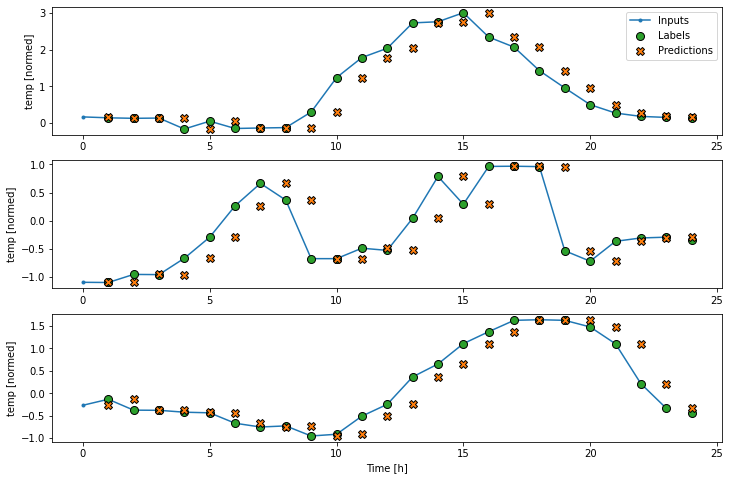

In [41]:
wider_step_window.plot(model=baseline)

#### **Linear model**

The trainable model that make a linear transformation to get the output of a timestep from only the input of that step.

In [42]:
linear = tf.keras.Sequential([
  tf.keras.layers.Dense(units=1)
])

In [43]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 13)
Output shape: (32, 1, 1)


Defining a reuseable function that pack all training procedures into one. 

In [44]:
MAX_EPOCHS = 15

def compile_and_fit(model, window, patience=2):
  # Stop training when the metric does not improve
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  # Define optimizer, loss function and metric
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  # Start training and record history
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  
  return history

Train the linear model and evaluate it

In [45]:
history = compile_and_fit(linear, single_step_window)

print("------ Evaluate ------")
val_performance['Linear'] = linear.evaluate(single_step_window.val, verbose=1)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=1)

Epoch 1/15
3966/3966 [==============================] - 38s 9ms/step - loss: 0.1330 - mean_absolute_error: 0.2431 - val_loss: 0.0659 - val_mean_absolute_error: 0.1834
Epoch 2/15
3966/3966 [==============================] - 43s 11ms/step - loss: 0.0723 - mean_absolute_error: 0.1907 - val_loss: 0.0654 - val_mean_absolute_error: 0.1815
Epoch 3/15
3966/3966 [==============================] - 37s 9ms/step - loss: 0.0722 - mean_absolute_error: 0.1906 - val_loss: 0.0658 - val_mean_absolute_error: 0.1843
Epoch 4/15
3966/3966 [==============================] - 40s 10ms/step - loss: 0.0722 - mean_absolute_error: 0.1906 - val_loss: 0.0656 - val_mean_absolute_error: 0.1832
------ Evaluate ------
567/567 [==============================] - 4s 7ms/step - loss: 0.0842 - mean_absolute_error: 0.2108


In [46]:
print('Input shape:', wider_step_window.example[0].shape)
print('Output shape:', baseline(wider_step_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


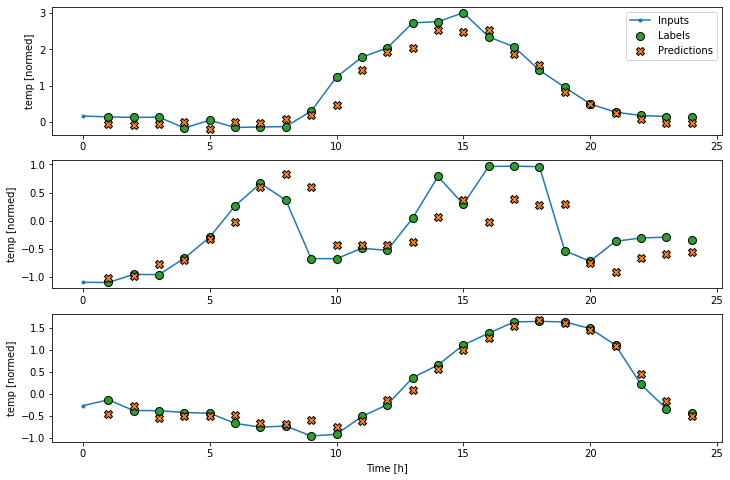

In [47]:
wider_step_window.plot(model=linear)

From a glance, it seems like the predictions of the linear model is slightly better than the single step model in some cases. However, in the third batch, some predictions looks even worse.

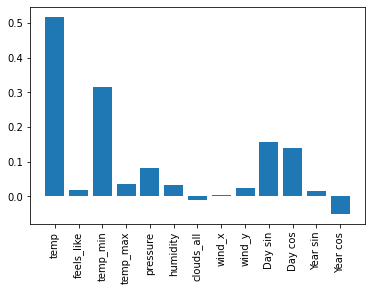

In [48]:
# Plot the histogram of the weights of attributes
plt.bar(x=range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())

axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

As far we have investigated the performance of the single step models. Before heading on to the mutilple timesteps model, we will check out the performance of the more complex and deeper model structure, which stacks several `Dense` layers and their activation function between the input and output layer.

#### **Linear (Dense) model**

In [49]:
dense = tf.keras.Sequential([
  tf.keras.layers.Dense(units=64, activation='relu'),
  tf.keras.layers.Dense(units=64, activation='relu'),
  tf.keras.layers.Dense(units=1)
])

In [50]:
history = compile_and_fit(dense, single_step_window)

print("------ Evaluate ------")
val_performance['Dense'] = dense.evaluate(single_step_window.val, verbose=1)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=1)

Epoch 1/15
3966/3966 [==============================] - 59s 15ms/step - loss: 0.0607 - mean_absolute_error: 0.1707 - val_loss: 0.0528 - val_mean_absolute_error: 0.1608
Epoch 2/15
3966/3966 [==============================] - 68s 17ms/step - loss: 0.0544 - mean_absolute_error: 0.1601 - val_loss: 0.0540 - val_mean_absolute_error: 0.1611
Epoch 3/15
3966/3966 [==============================] - 62s 16ms/step - loss: 0.0528 - mean_absolute_error: 0.1567 - val_loss: 0.0505 - val_mean_absolute_error: 0.1572
Epoch 4/15
3966/3966 [==============================] - 49s 12ms/step - loss: 0.0514 - mean_absolute_error: 0.1539 - val_loss: 0.0517 - val_mean_absolute_error: 0.1576
Epoch 5/15
3966/3966 [==============================] - 60s 15ms/step - loss: 0.0504 - mean_absolute_error: 0.1520 - val_loss: 0.0524 - val_mean_absolute_error: 0.1620
------ Evaluate ------
567/567 [==============================] - 6s 11ms/step - loss: 0.0665 - mean_absolute_error: 0.1853


Up to this point, the single timestep model does not provide much valuable information or context about the inputs. It actually cannot see the changes of the input features over the time because we only take value at one step of the present to predict one step of the future (as we have configured the parameter for the single_step_window below)

```
single_step_window = WindowFrame(input_width=1, label_width=1, offset=1,
                                 label_cols=['temp'])
```

We will try on the new model the take in mutliple time steps when making prediction.

In [51]:
CONV_WIDTH = 5

conv_window = WindowFrame(input_width=CONV_WIDTH,
                          label_width=1,
                          offset=1,
                          label_cols=['temp'])

conv_window

Total window width: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['temp']

Text(0.5, 1.0, 'Given 5 hours of input features, predict output 1 hour into the future')

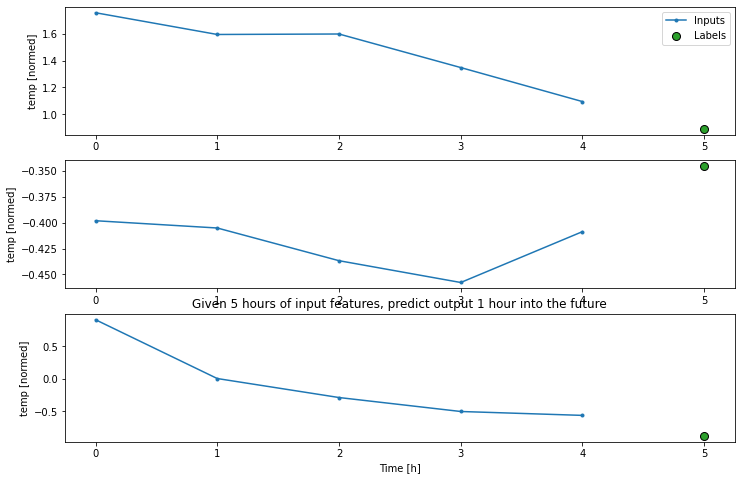

In [52]:
conv_window.plot()
plt.title("Given 5 hours of input features, predict output 1 hour into the future")

Since the new input now has the shape of (timesteps, features), with `time` indicates the number of timesteps (5 in the example above), we need to redefine the model sequence by using the `Flatten` layer.

In [53]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (timesteps, features) => (timesteps * features) after being flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Reshape the dimension to get the timesteps again
    # Shape (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1])
])

In [54]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 5, 13)
Output shape: (32, 1, 1)


In [55]:
history = compile_and_fit(multi_step_dense, conv_window)

print("------ Evaluate ------")
val_performance['Multi step Dense'] = multi_step_dense.evaluate(conv_window.val, verbose=1)
performance['Multi step Dense'] = multi_step_dense.evaluate(conv_window.test, verbose=1)

Epoch 1/15
3966/3966 [==============================] - 52s 13ms/step - loss: 0.0628 - mean_absolute_error: 0.1740 - val_loss: 0.0538 - val_mean_absolute_error: 0.1629
Epoch 2/15
3966/3966 [==============================] - 53s 13ms/step - loss: 0.0537 - mean_absolute_error: 0.1588 - val_loss: 0.0572 - val_mean_absolute_error: 0.1744
Epoch 3/15
3966/3966 [==============================] - 49s 12ms/step - loss: 0.0518 - mean_absolute_error: 0.1551 - val_loss: 0.0505 - val_mean_absolute_error: 0.1594
Epoch 4/15
3966/3966 [==============================] - 59s 15ms/step - loss: 0.0507 - mean_absolute_error: 0.1533 - val_loss: 0.0514 - val_mean_absolute_error: 0.1624
Epoch 5/15
3966/3966 [==============================] - 49s 12ms/step - loss: 0.0498 - mean_absolute_error: 0.1517 - val_loss: 0.0524 - val_mean_absolute_error: 0.1658
------ Evaluate ------
567/567 [==============================] - 5s 8ms/step - loss: 0.0621 - mean_absolute_error: 0.1833


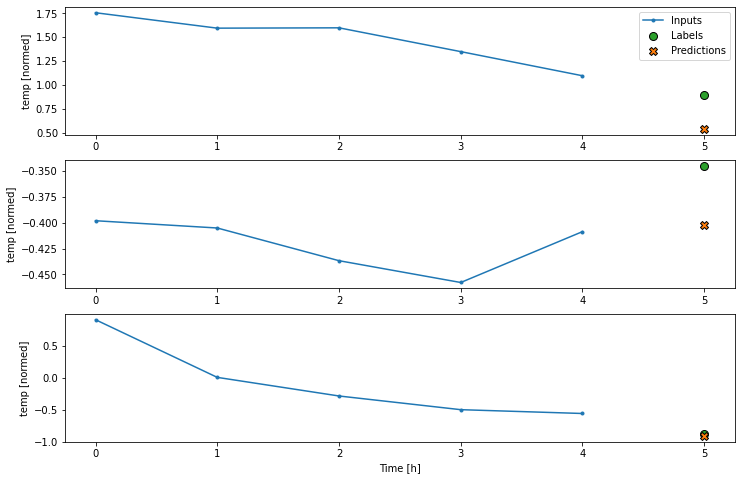

In [56]:
conv_window.plot(multi_step_dense)

However, the drawback of this approach is the trained model can only be exeucted with the input windows of exactly the shape that it has been trained on.

In [57]:
# Try out new window shape
print('Input shape:', wider_step_window.example[0].shape)
try:
    print('Ouput shape:', multi_step_dense(wider_step_window.example[0].shape))
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 13)

AttributeError:Exception encountered when calling layer "sequential_2" (type Sequential).

'TensorShape' object has no attribute '_keras_mask'

Call arguments received:
  • inputs=TensorShape([32, 24, 13])
  • training=None
  • mask=None


The `wider_step_window` that we have defined to use 24 hour inputs to predict 24 hours output into the future cannot be used for the multi dense model. This is because the shape does not match to model preferences and hence they will contradict to each other's settings.

#### **Convolution neural network**

As we have discovered the problem with the multiple step dense above, a convolution layer could address this issue. The `tf.keras.layers.Conv1D` can take up multiple time steps as input to each prediction.

The new model with Conv1D would behave similarly to the `multi_step_dense` model, except it can be executed on inputs of any length instead of having fixed inputs shape.

In [58]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [59]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Input shape: (32, 5, 13)
Output shape: (32, 1, 1)


In [60]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
print("------ Evaluate ------")
val_performance['Conv'] = conv_model.evaluate(conv_window.val, verbose=1)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=1)

------ Evaluate ------
567/567 [==============================] - 5s 8ms/step - loss: 0.0589 - mean_absolute_error: 0.1753


In [61]:
# Try on wider window
print("Wider step window")
print('Input shape:', wider_step_window.example[0].shape)
print('Labels shape:', wider_step_window.example[1].shape)
print('Output shape:', conv_model(wider_step_window.example[0]).shape)

Wider step window
Input shape: (32, 24, 13)
Labels shape: (32, 24, 1)
Output shape: (32, 20, 1)


We can see that the shape of labels and output does not match. Therefore, we can add a few extra timestep for the input so the output sizes will be the same.

In [62]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

wider_conv_window = WindowFrame(input_width=INPUT_WIDTH,
                                label_width=LABEL_WIDTH,
                                offset=1,
                                label_cols=['temp'])

wider_conv_window

Total window width: 29
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Label indices: [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28]
Label column name(s): ['temp']

In [63]:
# Try on wider window
print("Wider step window")
print('Input shape:', wider_conv_window.example[0].shape)
print('Labels shape:', wider_conv_window.example[1].shape)
print('Output shape:', conv_model(wider_conv_window.example[0]).shape)

Wider step window
Input shape: (32, 28, 13)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now we will plot the new wider convolution window. As we define the `CONV_WIDTH = 5`, the input time steps will have 5 steps preceding in time before the first prediction appears (notice the first 5 ticks).

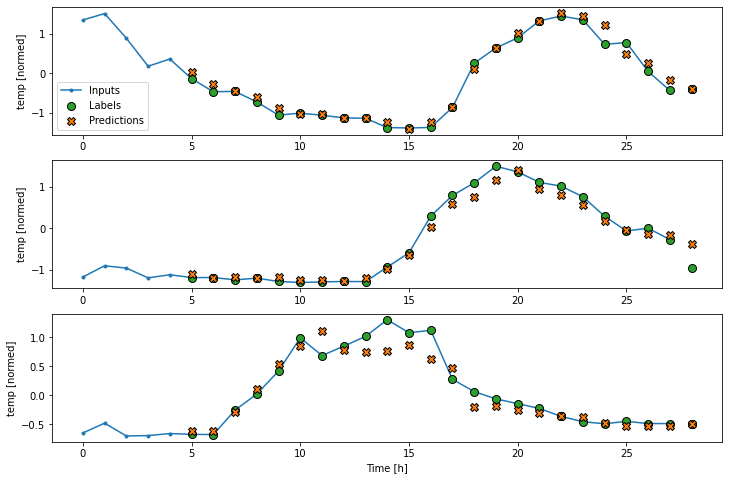

In [64]:
wider_conv_window.plot(conv_model)

It seems like the performance is getting slightly better compared to the previous models. The stacks witnessed some error cases, but in almost of the cases, they predicted very well.

#### **Recurrent neural network**

For the Recurrent Neural Network, we will intepret the Long Short-Term Memory (LSTM) model.

In [65]:
lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] -> [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [66]:
print('Input shape:', wider_step_window.example[0].shape)
print('Output shape:', lstm_model(wider_step_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


On the first step of training process, the LSTM model may behave similarly to `linear` and `dense` models since it has no access to the previous steps and maintain the internal states at that point.

In [67]:
history = compile_and_fit(lstm_model, wider_step_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wider_step_window.val)
performance['LSTM'] = lstm_model.evaluate(wider_step_window.test, verbose=0)

1133/1133 [==============================] - 10s 9ms/step - loss: 0.0482 - mean_absolute_error: 0.1537


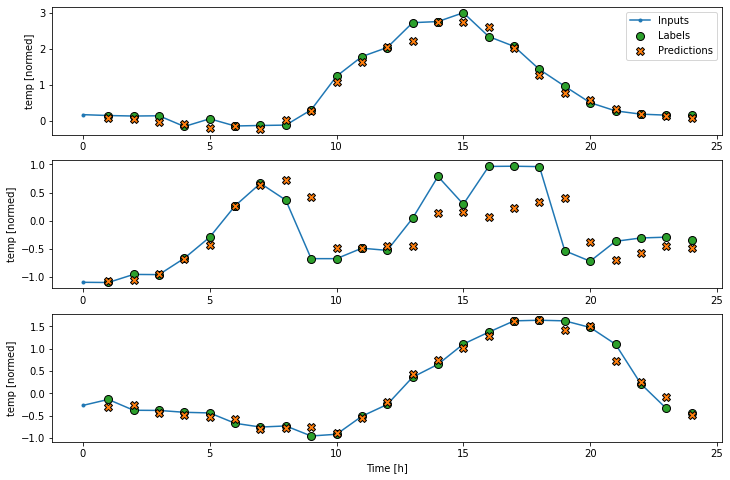

In [68]:
wider_step_window.plot(lstm_model)

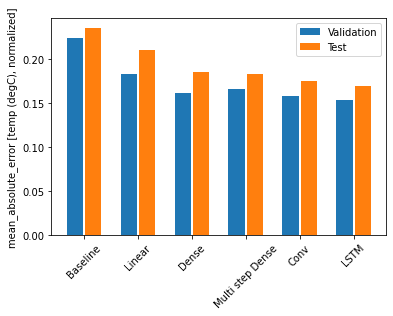

In [69]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [temp (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [70]:
for name, value in performance.items():
  print(f'{name:12s}: {value[metric_index]:0.4f}')

Baseline    : 0.2352
Linear      : 0.2108
Dense       : 0.1853
Multi step Dense: 0.1833
Conv        : 0.1753
LSTM        : 0.1702


From the performance comparison above, it seems like that the later models will work better than the previous one. The best model we had achieve is the LSTM, followed by the Convolutional and Dense models.

#### **Multi-output model**

All of the models we have implemented above predicted only one feature which is temperature, in a single time step.

To expand the project scope, we could adjust these models to predict multiple features by changing the number of output units and include all features in the training windows.

In [71]:
single_step_window = WindowFrame(
    # `WindowFrame` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, offset=1)

wide_window = WindowFrame(
    input_width=24, label_width=24, offset=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 13)
Labels shape (batch, time, features): (32, 24, 13)


Comparing to single-output model, our windows now has its number of features in Label layer equally the same with the Input layer (13 features).

**Baseline**

In [72]:
# Exclude the label_index for baseline class to get all features fed.
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [73]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

1133/1133 [==============================] - 9s 8ms/step - loss: 0.1878 - mean_absolute_error: 0.2445


**Dense**

In [74]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=n_features)
])

In [75]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

1133/1133 [==============================] - 10s 9ms/step - loss: 0.1306 - mean_absolute_error: 0.2140


**Recurrent neural network**

In [76]:
%%time
wide_window = WindowFrame(
    input_width=24, label_width=24, offset=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=n_features)
])

history = compile_and_fit(lstm_model, wider_step_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wider_step_window.val)
performance['LSTM'] = lstm_model.evaluate(wider_step_window.test, verbose=0)

print()

1133/1133 [==============================] - 10s 9ms/step - loss: 0.0471 - mean_absolute_error: 0.1506

CPU times: user 8min 12s, sys: 1min 31s, total: 9min 44s
Wall time: 7min 51s


**Residual Network (ResNet)**

The main aim of this architecture is that the results from each layers are added into the model's accumulating result. It predicts how the value will change instead of predicting what the value will be.

In [77]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        return inputs + delta

In [78]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=n_features,
                          # Initializer the output layer (aka the input layer of the next step)
                          # so when it added with the delta, the results will not be dramatically large
                          kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wider_step_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wider_step_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wider_step_window.test, verbose=0)

print()

1133/1133 [==============================] - 10s 9ms/step - loss: 0.0474 - mean_absolute_error: 0.1507

CPU times: user 15min 54s, sys: 2min 55s, total: 18min 50s
Wall time: 14min 52s


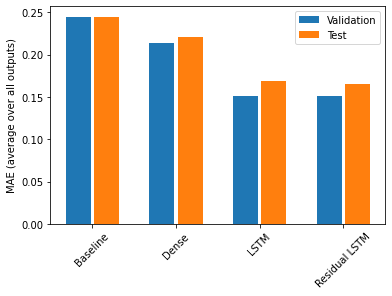

In [79]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('MAE (average over all outputs)')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

Up to this point, we will save this performance comparision between single-step multi-output models for references in the future.

In [137]:
mae_test = pd.DataFrame.from_dict(performance, orient='index', columns=['loss','mae'])
mae_val = pd.DataFrame.from_dict(val_performance, orient='index', columns=['val_loss', 'val_mae'])

comparision = pd.concat([mae_test, mae_val], axis=1)[['loss', 'val_loss', 'mae', 'val_mae']]

comparision

output_path = '/content/drive/MyDrive/Colab Notebooks/Weather Forecasting/performance/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
    print("Performance storage folder created")

comparision.to_csv(output_path + "mae_multi_output_comparision.csv")

Performance storage folder created


In [138]:
pd.read_csv(output_path + "mae_multi_output_comparision.csv")

,Unnamed: 0,loss,val_loss,mae,val_mae
0,Baseline,0.184394,0.187757,0.243803,0.244543
1,Dense,0.132158,0.130600,0.221103,0.213963
2,LSTM,0.058032,0.047056,0.168804,0.150596
3,Residual LSTM,0.056757,0.047352,0.165770,0.150687


### **Multi-step models**

The above single-output and multi-output models shared one characteristic that is making only **single time step prediction** into the future (only different in number of output attributes).

In this section, we will focus on the more advanced version of these models where they will make **multiple time step prediction**. It is in fact our ultimate goal upon this notebook.

*The difference between single-step prediction and multi-steps prediction*

![picture](https://drive.google.com/uc?export=view&id=1NjqcEMv3mzINaQWJtXD-ZKJX3KUGKbP4)

From the recommendations of TensorFlow documentations, there are two approaches to predict a sequence of future values:


1.   Predicts future values in the time series at once (single shot)
2.   Autoregressive where model will make single step predictions and the output will be fed back again as input

We will implement such models that will predict all features across all output time steps.



Total window width: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

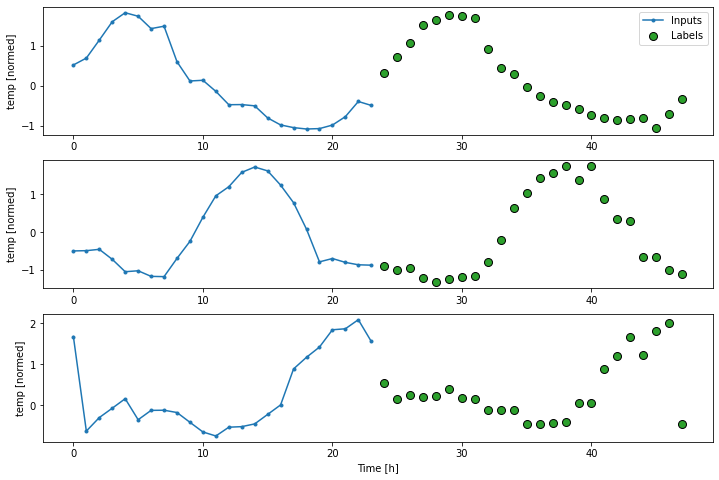

In [169]:
OUT_STEPS = 24
# As said, we will predict all features, so the columns parameter will be left empty
multi_window = WindowFrame(input_width=24, label_width=OUT_STEPS, offset=OUT_STEPS)

multi_window.plot()
multi_window

#### **Baseline**

The most basic baseline model which will repeat the last input time step to get the desired number of output time steps.

1132/1132 [==============================] - 9s 8ms/step - loss: 1.1145 - mean_absolute_error: 0.7423


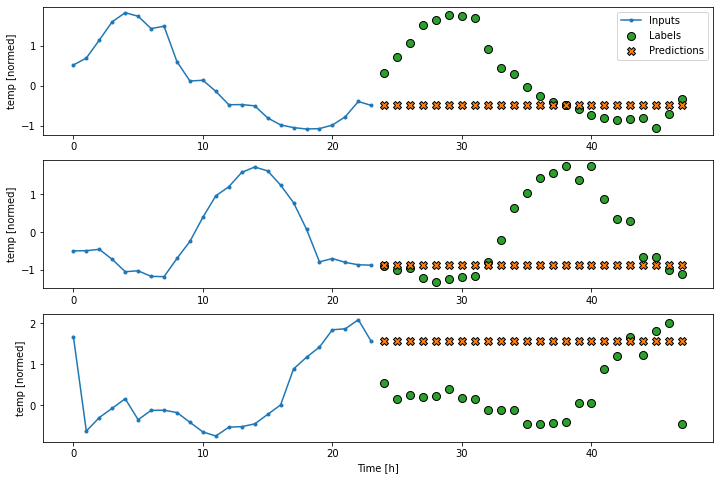

In [170]:
class MultiStepBaseline(tf.keras.Model):
  def call(self, inputs):
      # tf.tile will replicate input[i] for multiples[i] time
      return tf.tile(input=inputs[:, -1:, :], multiples=[1, OUT_STEPS, 1])

last_baseline = MultiStepBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_performance = {}
multi_val_performance = {}

multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_window.plot(last_baseline)

This model is ... pretty obvious since we just repeat the last input time steps into the future predictions for 24 hours.

The next simple baseline is the RepeatBaseline which will exactly replicate the previous input time steps for the future predictions.

1132/1132 [==============================] - 11s 10ms/step - loss: 0.3659 - mean_absolute_error: 0.3418


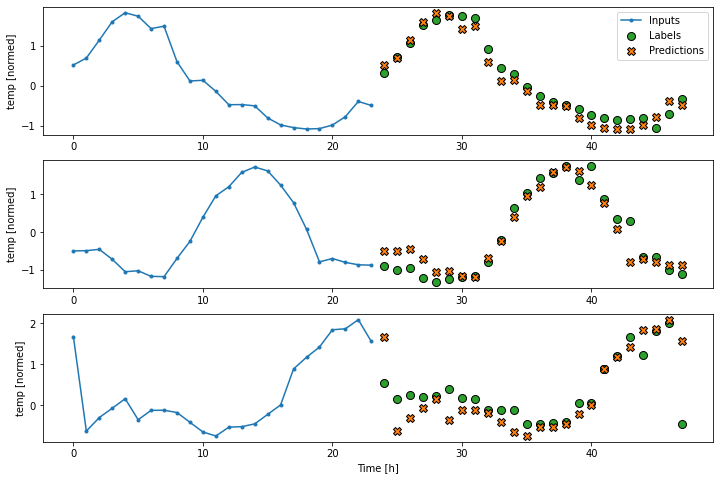

In [172]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

Very straightforwarding model yet not too accurate and optimized for more complex patterns.

#### **Single-shot Model**

### **4.2 Dataset Extraction**

**Getting data from OpenWeather every 6 minutes (Free plan)**

In [ ]:
import requests
import json
api_key = "08d3a5fe27dbddc8ff36a36e3690f636"
lat = "10.823099"
lon = "106.629662"
url = "https://api.openweathermap.org/data/2.5/onecall?lat=%s&lon=%s&appid=%s&units=metric" % (lat, lon, api_key)

response = requests.get(url)
data = json.loads(response.text)


In [ ]:
data_temp = data['current']
data_temp

{'clouds': 75,
 'dew_point': 23.98,
 'dt': 1627566171,
 'feels_like': 26.02,
 'humidity': 94,
 'pressure': 1009,
 'rain': {'1h': 0.15},
 'sunrise': 1627512082,
 'sunset': 1627557500,
 'temp': 25.01,
 'uvi': 0,
 'visibility': 8000,
 'weather': [{'description': 'light rain',
   'icon': '10n',
   'id': 500,
   'main': 'Rain'}],
 'wind_deg': 250,
 'wind_speed': 3.09}

In [ ]:
for i in range(len(data_temp)):

    data_temp[i]['weather'] = data_temp[i]['weather'][0]['main']

    data_temp[i]['temp_max'] = data_temp[i]['temp']['max']
    data_temp[i]['temp_min'] = data_temp[i]['temp']['min']

    data_temp[i].pop('temp')
    data_temp[i].pop('feels_like')

In [ ]:
#@title
import time
starttime = time.time()
iter = 1

while True:
    response = requests.get(url)
    data = json.loads(response.text)

    data_temp = data['current']
    data_temp['weather'] = data_temp['weather'][0]['main']

    dataset.append(data_temp)

    print("Data Fetching ", iter)
    iter+=1

    time.sleep(30.0 - ((time.time() - starttime) % 30.0))

In [ ]:
output_df = pd.DataFrame(data_temp)

In [ ]:
output_df = output_df.drop(columns=['dt', 'sunrise', 'sunset', 'moonrise', 'moonset', 'weather'])

In [ ]:
output_df.to_csv("hcm_weather.csv", index=False)

In [ ]:
df_train = output_df

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   moon_phase  8 non-null      float64
 1   pressure    8 non-null      int64  
 2   humidity    8 non-null      int64  
 3   dew_point   8 non-null      float64
 4   wind_speed  8 non-null      float64
 5   wind_deg    8 non-null      int64  
 6   wind_gust   8 non-null      float64
 7   clouds      8 non-null      int64  
 8   pop         8 non-null      float64
 9   rain        8 non-null      float64
 10  uvi         8 non-null      float64
 11  temp_max    8 non-null      float64
 12  temp_min    8 non-null      float64
dtypes: float64(9), int64(4)
memory usage: 960.0 bytes


In [ ]:
df_train.head(10)

,moon_phase,pressure,humidity,dew_point,wind_speed,wind_deg,wind_gust,clouds,pop,rain,uvi,temp_max,temp_min
0,0.32,1009,50,21.86,5.70,253,9.83,44,0.88,0.43,12.65,35.58,25.49
1,0.36,1008,60,23.11,6.70,260,11.12,91,0.99,12.69,12.69,33.68,24.79
2,0.40,1009,58,22.93,5.60,262,11.04,29,0.92,10.93,6.57,32.84,24.97
3,0.44,1010,61,22.96,5.46,255,9.84,98,0.76,2.72,10.11,32.69,24.98
4,0.48,1009,60,22.57,4.69,235,10.20,97,0.93,1.48,8.67,32.18,25.17
5,0.50,1008,62,22.82,4.85,264,9.73,97,0.99,8.97,9.00,30.75,25.09
6,0.56,1009,64,23.62,5.25,242,8.98,82,0.81,2.34,9.00,32.38,24.87
7,0.59,1009,65,23.60,4.17,242,9.96,100,0.82,1.79,9.00,32.63,25.80


In [ ]:
target = df_train['temp_max']
df_train.drop(columns='temp_max')

,moon_phase,pressure,humidity,dew_point,wind_speed,wind_deg,wind_gust,clouds,pop,rain,uvi,temp_min
0,0.32,1009,50,21.86,5.70,253,9.83,44,0.88,0.43,12.65,25.49
1,0.36,1008,60,23.11,6.70,260,11.12,91,0.99,12.69,12.69,24.79
2,0.40,1009,58,22.93,5.60,262,11.04,29,0.92,10.93,6.57,24.97
3,0.44,1010,61,22.96,5.46,255,9.84,98,0.76,2.72,10.11,24.98
4,0.48,1009,60,22.57,4.69,235,10.20,97,0.93,1.48,8.67,25.17
5,0.50,1008,62,22.82,4.85,264,9.73,97,0.99,8.97,9.00,25.09
6,0.56,1009,64,23.62,5.25,242,8.98,82,0.81,2.34,9.00,24.87
7,0.59,1009,65,23.60,4.17,242,9.96,100,0.82,1.79,9.00,25.80


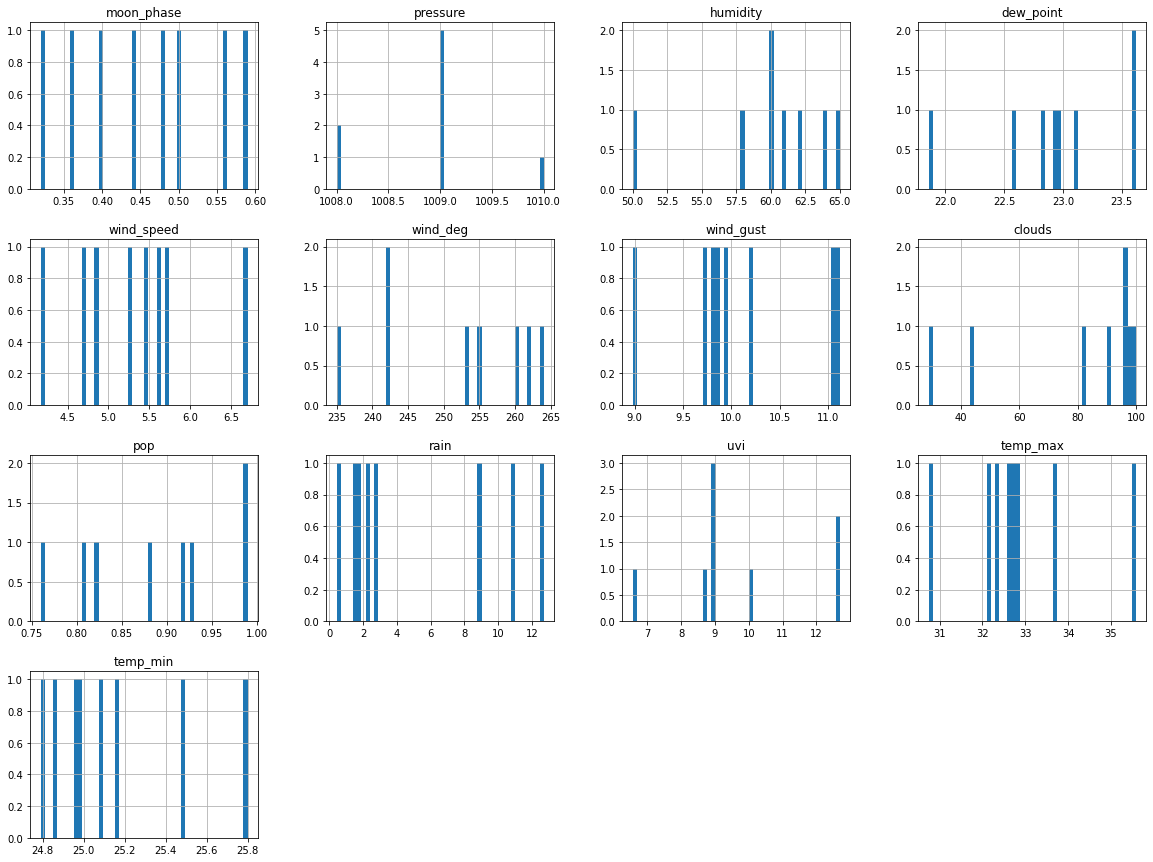

In [ ]:
df_train.hist(bins=50, figsize=(20, 15))
plt.show()

**Correlation matrix**

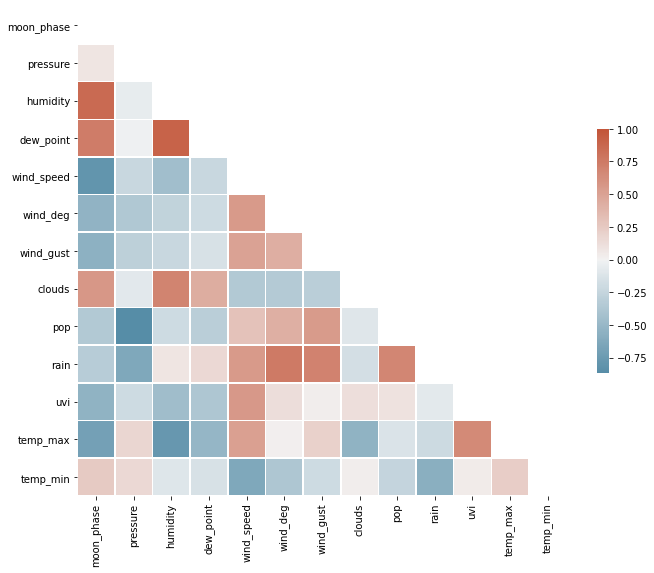

In [ ]:
corr = df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sn.diverging_palette(230, 20, as_cmap=True)

sn.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**3. Pipeline implementation**

**Removing label from dataset**

**K-Fold Validator**

Since we only have train and test dataset, using KFold will enable us to create validation dataset during the training process.

The original train dataset will be divided into N groups, and during each training iteration, N-1 parts will be used for training, and the remaining part will be use for validation. This would help us to prevent overfiting without using the test dataset in the beginning.

In [ ]:
from sklearn.model_selection import KFold
# Prepare cross validation
kfolds = KFold(n_splits=5, shuffle=True, random_state=1)

**Pipeline**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

lg_model = Pipeline([('scaler', StandardScaler()),
                      ('estimator', LinearRegression())])

**GridSearch CV**

GirdSearch CV is used to find out the best hyperparameter settings for our estimator algorithm.

In [ ]:
from sklearn.model_selection import GridSearchCV

## Search grid for optimal parameters
lg_grid = [{'estimator__fit_intercept':[True,False], 
             'estimator__normalize':[True,False],
             'estimator__copy_X':[True, False]}]

**Train the model**

In [ ]:
final_model = GridSearchCV(lg_model, param_grid = lg_grid, scoring='neg_mean_absolute_error', cv=kfolds, verbose=1)
final_model.fit(df_train, target)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.4s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('estimator',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'estimator__copy_X': [True, False],
                          'estimator__fit_intercept': [True, False],
                          'esti

In [ ]:
print("Best hyperparameters setting: \n{}".format(final_model.best_params_))

Best hyperparameters setting: 
{'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__normalize': False}


**Predict the test dataset**

In [ ]:
from sklearn.metrics import mean_squared_error
pred_y = final_model.predict(df_train)
mean_squared_error(pred_y, target)

0.0

**Scatter the plot of predictions based on few features**

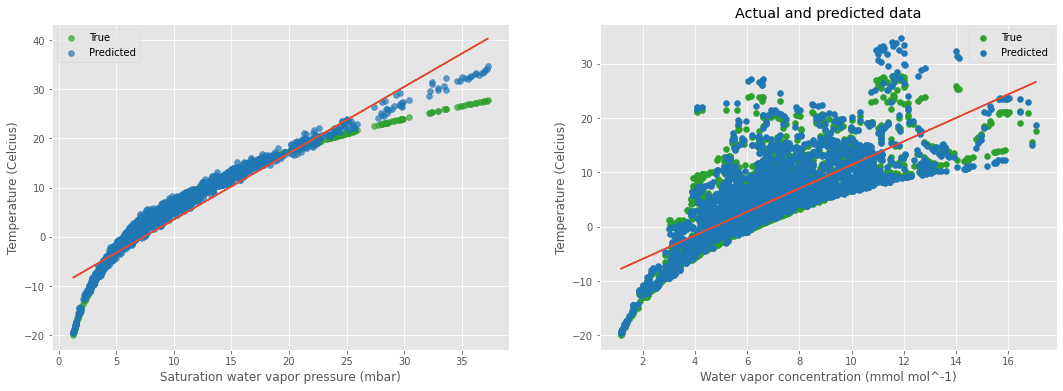

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18,6))
plt.title('Actual and predicted data')
plt.style.use('ggplot')
# Scatter plot
axs[0].scatter(test_x['VPmax (mbar)'], test_y, color="tab:green", label="True", alpha=0.7)
axs[0].scatter(test_x['VPmax (mbar)'], pred_y, color="tab:blue", label="Predicted", alpha=0.7)

# Fit line
m1, b1 = np.polyfit(test_x['VPmax (mbar)'], pred_y, 1)
axs[0].plot(test_x['VPmax (mbar)'], m1*test_x['VPmax (mbar)'] + b)

axs[0].set_xlabel('Saturation water vapor pressure (mbar)')
axs[0].set_ylabel('Temperature (Celcius)')
axs[0].legend()

axs[1].scatter(test_x['H2OC (mmol/mol)'], test_y, color="tab:green", label="True")
axs[1].scatter(test_x['H2OC (mmol/mol)'], pred_y, color="tab:blue", label="Predicted")

# Fit line
m2, b2 = np.polyfit(test_x['H2OC (mmol/mol)'], pred_y, 1)
axs[1].plot(test_x['H2OC (mmol/mol)'], m2*test_x['H2OC (mmol/mol)'] + b2)

axs[1].set_xlabel('Water vapor concentration (mmol mol^-1)')
axs[1].set_ylabel('Temperature (Celcius)')
axs[1].legend()

**Predict randomly**

In [ ]:
df_X = df_final_test.drop("T (degC)", axis=1).copy()
df_X = df_X[["VPmax (mbar)",  "VPdef (mbar)", "Tlog (degC)", "Tdew (degC)",
                   "VPdef (mbar)", "VPact (mbar)", "H2OC (mmol/mol)", "sh (g/kg)"]]

In [ ]:
y_pred = final_model.predict(df_X)
y_true = df_final_test['T (degC)']
print("True value: {}\nPredicted value: {}".format(list(y_true.values), list(np.round(y_pred,2))))

True value: [14.41, 14.07, 14.05, 14.67, 14.95, 14.8, 14.66, 14.76]
Predicted value: [15.73, 15.33, 15.21, 15.56, 15.7, 15.59, 15.46, 15.53]


**Conclusion**

The predicted temperature is less than the true temperature approximately 1.3 in average from the above results. In the reality, difference in 1-2 degree of Celcius is not really a big problem (maybe to me). In the end, the model works out and can forecast in a decent accuracy. Neverthless, similarly to Section 3. Addition Function, this problem still have some spaces for improvements regarding the accuracy of the model.